# <b>FrozenLake 4x4 Environment</b>

In this colab notebook, we'll implement an agent <b>that plays FrozenLake.</b>

![alt text](http://simoninithomas.com/drlc/Qlearning/frozenlake4x4.png)

The goal of this game is <b>to go from the starting state (S) to the goal state (G)</b> by walking only on frozen tiles (F) and avoid holes (H). However, the ice is slippery, **so you won't always move in the direction you intend (stochastic environment)**

Reference:
- Grokking - Deep Reinforcement Learning


## Step 0: Install the dependencies on Google Colab

In [4]:
# !pip install setuptools==65.5.0
!pip install numpy
!pip install gym==0.19.0
#!pip install gym
!pip install tqdm
!pip install scipy

     ---------------------------------------- 0.0/42.2 MB ? eta -:--:--
      --------------------------------------- 0.5/42.2 MB 11.1 MB/s eta 0:00:04
     - -------------------------------------- 1.4/42.2 MB 15.3 MB/s eta 0:00:03
     -- ------------------------------------- 2.2/42.2 MB 15.5 MB/s eta 0:00:03
     --- ------------------------------------ 3.3/42.2 MB 17.5 MB/s eta 0:00:03
     --- ------------------------------------ 4.0/42.2 MB 16.9 MB/s eta 0:00:03
     ---- ----------------------------------- 5.2/42.2 MB 18.3 MB/s eta 0:00:03
     ---- ----------------------------------- 5.2/42.2 MB 18.5 MB/s eta 0:00:03
     ---- ----------------------------------- 5.2/42.2 MB 18.5 MB/s eta 0:00:03
     ----- ---------------------------------- 5.3/42.2 MB 13.6 MB/s eta 0:00:03
     ----- ---------------------------------- 5.3/42.2 MB 13.6 MB/s eta 0:00:03
     ----- ---------------------------------- 5.4/42.2 MB 11.1 MB/s eta 0:00:04
     ----- ---------------------------------- 5.

## Step 1: Import the dependencies 📚
We use 4 libraries:
- `numpy` for Q-table
- `random` for random number generation
- `OpenAI Gym` for FrozenLake Environment
- `tqdm` for visualizing loop progress
- `matplotlib` for graph visualization

In [2]:
import gym
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

## Step 2: Create the environment 🎮
- Here we'll create the FrozenLake 4x4 environment.
- We can see the map via <b>env.render()</b>

In [5]:
env = gym.make("FrozenLake-v1")

print('There are total {} states'.format(env.observation_space.n))
print('There are total {} actions'.format(env.action_space.n))

env.render()

There are total 16 states
There are total 4 actions

SFFF
FHFH
FFFH
HFFG


  - Now we apply some random actions, and see what environment returns!

In [6]:
state = env.reset()
print('initial state: ', state)
env.render()
action = random.randint(0, 3)
print('random action: ', action)
next_state, reward, done, _ = env.step(action)
print('next state: {}, reward: {}, game ended: {}'.format(next_state, reward, done))
env.render()

initial state:  0

SFFF
FHFH
FFFH
HFFG
random action:  1
next state: 0, reward: 0.0, game ended: False
  (Down)
SFFF
FHFH
FFFH
HFFG


## Step 3: Preview Learning 🗄️
Now, we'll iterate overall learning process once.
- There are some hyperparameters used in learning process:
  - `n_episodes`: total number of episodes that agent will play to learn Q-table
  - `𝛼`: learning rate; balancing old Q-value and new Q-value
  - `max_steps`: maximum number of steps that agent can take in each episode
  - `𝛾`: gamma, discount rate
- There are some parameters about exploration:
  - `epsilon`: exploration rate

### Step 3-1: Create empty Q-table
  - <b>Q-table:</b> used to record value of action given state

### Step 3-2: define generate trajectory function
  - <b>generate_trajectory:</b> returns a set of experience; each experience has a form of (state, action, reward, next_state, done)

In [7]:
nS, nA = env.observation_space.n, env.action_space.n
Q = np.zeros((nS, nA), dtype=np.float64)
print('Empty Q-table: ', Q)
epsilon = 1

def generate_trajectory(Q, epsilon, env, max_steps=100):
    done, trajectory = False, []
    while not done:
        state = env.reset()
        for t in range(max_steps):
            # epsilon-greedy
            if random.random() < epsilon:
                action = random.randint(0, 3)
            else:
                action = np.argmax(Q[state])
            next_state, reward, done, _ = env.step(action)
            experience = (state, action, reward, next_state, done)
            trajectory.append(experience)
            if done:
                break
            if t >= max_steps - 1:
                trajectory = []
                break
            state = next_state
    return np.array(trajectory)

trajectory = generate_trajectory(Q, epsilon, env, max_steps=100)
print('trajectory:')
print(trajectory)

Empty Q-table:  [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
trajectory:
[[0. 2. 0. 4. 0.]
 [4. 1. 0. 5. 1.]]


### Step 3-3: set hyperparameters ⚙️
- Here, we'll specify the hyperparameters
  - `max_steps`: maximum number of steps that agent can take in each episode
  - `n_episodes`: total number of episodes that agent will play to learn Q-table
  - `𝛾`: gamma, discount rate. `discounts` contains squares of `𝛾`.
  - `𝛼`: learning rate; balancing old Q-value and new Q-value
- There are some parameters about exploration:
  - `epsilon`: exploration rate, decay over episodes

In [8]:
# some parameters; will explained later with details.
## in each episode, max step is 100
max_steps = 100
## we will total run 10,000 episodes
n_episodes = 10000

def decay_schedule(max_value, min_value, decay_ratio, steps, log_start=-2, log_base=10):
    decay_steps = int(steps * decay_ratio)
    rem_steps = steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min()) / (values.max() - values.min())
    values = (max_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

## discount rate gamma
gamma = 1.0
discounts = np.logspace(0, max_steps, num=max_steps, base=gamma, endpoint=False) 

## learning rate, alpha
max_alpha = 0.5
min_alpha = 0.01
alpha_decay_ratio = 0.5
alphas = decay_schedule(max_alpha, min_alpha, alpha_decay_ratio, n_episodes)

## Step 4: Learn Until Converge 🧠
### here we use Monte-Carlo method:

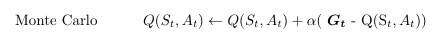

In [44]:
# recall other parameters
## state space, action space
nS, nA = env.observation_space.n, env.action_space.n
## create empty Q-table
Q = np.zeros((nS, nA), dtype=np.float64)

## in each episode, max step is 100
max_steps = 100
## we will total run 10,000 episodes
n_episodes = 10000

## discount rate, gamma
gamma = 1.0
discounts = np.logspace(0, max_steps, num=max_steps, base=gamma, endpoint=False) 

# exploration rate, epsilon
max_epsilon = 1.0
min_epsilon = 0.01
epsilon_decay_ratio = 0.9
epsilons = decay_schedule(max_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)

# learning rate, alphas:
max_alpha = 0.7
min_alpha = 0.01
alpha_decay_ratio = 0.5
alphas = decay_schedule(max_alpha, min_alpha, alpha_decay_ratio, n_episodes)

# we will not update same state twice in same trajectory
first_visit = True

# record episode rewards
epi_rew = []
for e in tqdm(range(n_episodes), leave=False):
    trajectory = generate_trajectory(Q, epsilons[e], env, max_steps)
    epi_rew.append(trajectory[-1][2])
    visited = np.zeros((nS, nA), dtype=bool)
    for t, (state, action, reward, _, _) in enumerate(trajectory):
        state = int(state)
        action = int(action)
        if visited[state][action] and first_visit:
            continue
        visited[state][action] = True
        
        n_steps = len(trajectory[t:])
        G = np.sum(discounts[:n_steps] * trajectory[t:, 2])
        ############# Update Q-table #############
        Q[state][action] = Q[state][action] + alphas[e] * (G - Q[state][action])

print('Learned Q-table:')
print(Q)
print('Learned Value of states:')
print(np.sum(Q, axis=1))

Learned Q-table:
[[7.01981629e-01 5.63386106e-01 5.32767222e-01 5.06632962e-01]
 [1.70564753e-01 1.95233676e-01 1.29473884e-01 4.30846723e-01]
 [3.69854298e-01 2.23231486e-01 2.00451843e-01 2.64052659e-01]
 [4.51248744e-02 4.85285189e-07 2.22696663e-02 1.98864075e-01]
 [7.03122214e-01 4.30733077e-01 3.55380506e-01 3.51404801e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.75724889e-01 1.00704096e-01 3.00650771e-01 5.62236632e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [3.52468253e-01 3.60167123e-01 3.71296474e-01 7.21570440e-01]
 [3.90242451e-01 7.28667493e-01 3.89453948e-01 3.69953875e-01]
 [6.51710621e-01 3.76126313e-01 3.03449791e-01 2.24818508e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [3.49627926e-01 3.71823462e-01 7.64584455e-01 4.10921143e-01]
 [5.79014087e-01 8.70068761e-01 7.55923997e-01 6.91740376e-01]
 [0.00000000e+00 0.00000000e+00 0.0000

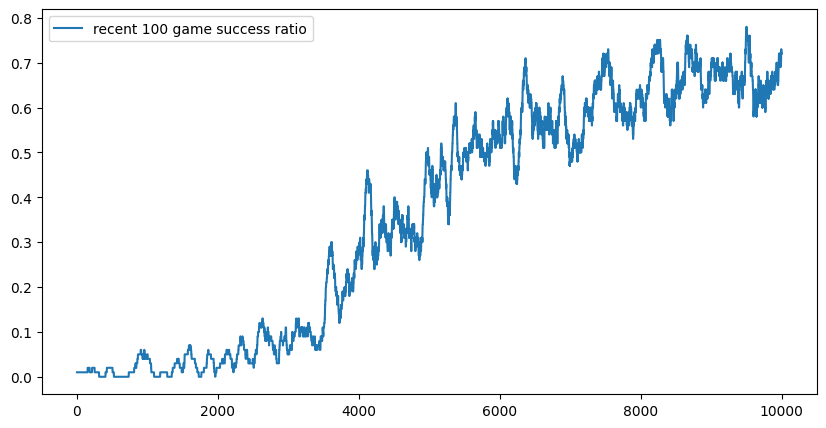

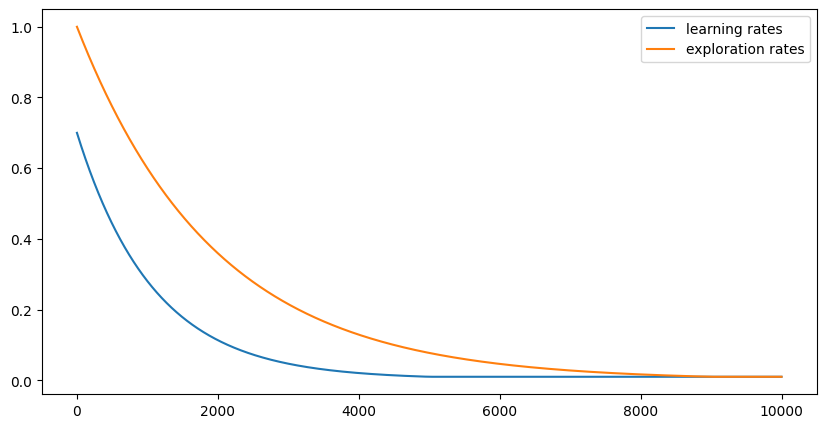

In [45]:
plt.figure(figsize=(10, 5))
plt.plot([np.mean(epi_rew[:100]) for i in range(100)] + [np.mean(epi_rew[i - 100:i]) for i in range(100, len(epi_rew))], label='recent 100 game success ratio')
plt.legend()
plt.show()
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(alphas, label='learning rates')
plt.plot(epsilons, label='exploration rates')
plt.legend()
plt.show()
plt.close()

## Step 5: Play with learnt Q-table! 👾
- <b>Exploitation:</b> follow the Q-table

In [52]:
for episode in range(5):
    state = env.reset()
    done = False
    print("****************************************************")
    print("EPISODE ", episode)

    for step in range(max_steps):
        # Take the action (index) that have the maximum expected future reward given that state
        action = np.argmax(Q[state])

        next_state, reward, done, info = env.step(action)

        if done:
            # Here, we decide to only print the last state (to see if our agent is on the goal or fall into an hole)
            env.render()
            if next_state == 15:
                print("We reached our Goal 🏆")
            else:
                print("We fell into a hole ☠️")

            # We print the number of step it took.
            print("Number of steps", step)

            break
        state = next_state
env.close()

****************************************************
EPISODE  0
  (Down)
SFFF
FHFH
FFFH
HFFG
We reached our Goal 🏆
Number of steps 83
****************************************************
EPISODE  1
  (Down)
SFFF
FHFH
FFFH
HFFG
We reached our Goal 🏆
Number of steps 5
****************************************************
EPISODE  2
  (Down)
SFFF
FHFH
FFFH
HFFG
We reached our Goal 🏆
Number of steps 15
****************************************************
EPISODE  3
  (Down)
SFFF
FHFH
FFFH
HFFG
We reached our Goal 🏆
Number of steps 25
****************************************************
EPISODE  4
  (Down)
SFFF
FHFH
FFFH
HFFG
We reached our Goal 🏆
Number of steps 10
